# Charge solver: a silicon electro-optic phase modulator

In this notebook, we simulate a silicon electro-optic phase modulator. The numerical results are compared with the experimental data provided in [1]. The modulator consists of a *pn*-junction with a high doping contact to allow for a less resistive electrical interface. 

The sketch below illustrates the main dimensions of the modulator:

![charge_modulator](img/charge_modulator.png)

### Outline

1. We start by setting up a `Charge` simulation in `tidy3d`. For this example, the isothermal Drift-Diffusion (DD) equations are solved. A basic summary of the equations solved and nomenclature used can be found our [td.SemiconductorMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SemiconductorMedium.html#tidy3d-semiconductormedium) documentation. 
2. We show how the numerical results from this simulation can be used to determine the optical phase change.

### References

[1] Chrostowski L, Hochberg M. Silicon Photonics Design: From Devices to Systems. Cambridge University Press; 2015.

[2] Schroeder, D., T. Ostermann, and O. Kalz. “Comparison of transport models far the simulation of degenerate semiconductors.” Semiconductor science and technology 9.4 (1994): 364.


## 1. Construct our `Charge` Simulation

In [1]:
import numpy as np
import tidy3d as td
from matplotlib import pyplot as plt
from tidy3d import web

### Specify our Modulator Dimensions

Based on the figure above, we can define the dimensions of our electro-optic phase modulator. These are defaulted to micro-meters.

Since 2D problems are not yet supported, we will extrude our geometry in the *z* dimension. This is perpendicular to the plane of the problem in `z_size` $\mu m$.

In [2]:
# all units in um
w_core = 0.5
h_core = 0.22

w_clearance = 2.25
h_clearance = 0.09
w_side = 2.5
h_side = 0.22

w_contact = 1.2
h_contact = 1.0

z_size = h_clearance / 5

res = h_clearance / 10

### Create Multi-Physical Mediums

In this example, we want to simulate the optical and electronic behaviour of this device. This means we need to specify material models that can represent the behaviour in these two physical domains. 

The [td.MultiPhysicsMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.components.material.multi_physics.MultiPhysicsMedium.html#tidy3d.components.material.multi_physics.MultiPhysicsMedium) was introduced in order to compose existing `tidy3d` medium models together into a unified multi-domain representation. `td.MultiPhysics` medium will be fully interoperable with any `tidy3d` simulation definition or class that uses existing medium definitions, and should enable full flexibility in terms of creating unified material models progressively. In this example, we will focus on its usage for Charge simulations which it fully supports.

We still need to define a `<Domain>Medium` model for our Charge and Optical FDTD simulations. Let's explore the different ways of doing this below.

Our silica ($SiO_2$) cladding behaves like an electronic insulator which can be defined with a [td.ChargeInsulatorMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ChargeInsulatorMedium.html#tidy3d.ChargeInsulatorMedium). For the optical simulation, assuming we have an `td.Medium` frequency range valid to 0 Hz (electronic DC), we can reuse a the [td.material_library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html) optical medium models and create a `td.MultiPhysicsMedium` accordingly:

In [3]:
SiO2_optic = td.material_library["SiO2"]["Palik_Lossless"]
SiO2 = td.MultiPhysicsMedium(
    optical=SiO2_optic,
    charge=td.ChargeInsulatorMedium(permittivity=SiO2_optic.eps_model(frequency=0)),
    name="SiO2",
)

19:32:03 CEST WARNING: frequency passed to 'Medium.eps_model()'is outside of    
              'Medium.frequency_range' = (59958491600000.0, 1998616386666666.8) 

/home/yannick/flexcompute/worktrees/release_29/.venv/lib/python3.13/site-packages/pydantic/v1/validators.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


However, in this example, we will create our own silica multi-physics model. The above `td.material_library['SiO2']['Palik_Lossless']` is not well defined for `frequency=0`. Hence, it is outside of the simulation validity region. 
<!-- Also, the mode solver doesn't yet support Multiphysics mediums. TODO remove Marc is this relevant for this simulation?-->

In [4]:
SiO2 = td.MultiPhysicsMedium(
    optical=td.Medium(permittivity=3.9),
    charge=td.ChargeInsulatorMedium(permittivity=3.9),  # redefining permittivity
    name="SiO2",
)

And now we define the remaining auxiliary mediums used to define our boundary conditions:

In [5]:
aux = td.MultiPhysicsMedium(charge=td.ChargeConductorMedium(conductivity=1), name="aux")

air = td.MultiPhysicsMedium(heat=td.FluidSpec(), name="air")

### A Drift-Diffusion Model defined in a `td.SemiconductorMedium`

We will begin defining the electronic properties of the intrinsic semiconductor: i.e., the [td.SemiconductorMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SemiconductorMedium.html) without any doping. 

Within a `SemiconductorMedium`, the Drift-Diffusion (DD) equations will be solved. In this example, we will explore an isothermal (constant temperature) case. This simulation performed at $ T=300 $ K. The DD equations, their assumptions, and limitations for this type of problem are discussed below:

The electrostatic potential $\psi$, the electron $n$ and hole $p$ concentrations are computed from the following coupled system of PDEs.

$$
-\nabla \cdot \left( \varepsilon_0 \varepsilon_r \nabla \psi \right) = q \left( p - n + N_d^+ - N_a^- \right)
$$

$$
q \frac{\partial n}{\partial t} = \nabla \cdot \mathbf{J}_n - qR
$$

$$
q \frac{\partial p}{\partial t} = -\nabla \cdot \mathbf{J}_p - qR
$$

The above system requires the definition of the generation-recombination rate $R$ represented by our [generation-recombination](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/charge/index.html#generation-recombination) models and the flux functions (free carrier current density), $\mathbf{J}_n$ and $\mathbf{J}_p$. Their usual form is:

$$
\mathbf{J}_n = q \mu_n \mathbf{F}_{n} + q D_n \nabla n
$$

$$
\mathbf{J}_p = q \mu_p \mathbf{F}_{p} - q D_p \nabla p
$$

These depend on the carrier mobility for electrons $\mu_n$ and holes $\mu_p$ represented by our [mobility models](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/charge/index.html#mobility).

Where the effective field, defined in [2], is simplified to:

$$
\mathbf{F}_{n,p} = \nabla \psi
$$

This approximation does not consider the effects of bandgap narrowing and degeneracy on the effective electric field $\mathbf{F}_{n,p}$, which is acceptable for non-degenerate semiconductors. [Bandgap narrowing models](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/charge/index.html#bandgap) which are important for doped semiconductor effects can also be defined.

Material properties are defined as class parameters or other classes:

| Symbol       | Parameter Name          | Description                                   |
|--------------|-------------------------|-----------------------------------------------|
| $$ N_a $$    | `N_a`                  | Ionized acceptors density                     |
| $$ N_d $$    | `N_d`                  | Ionized donors density                        |
| $$ N_c $$    | `N_c`                  | Effective density of states in the conduction band |
| $$ N_v $$    | `N_v`                  | Effective density of states in valence band   |
| $$ R $$      | `R`                    | Generation-Recombination term                |
| $$ E_g $$    | `E_g`                  | Bandgap Energy                                |
| $$ \Delta E_g $$ | `delta_E_g`         | Bandgap Narrowing                             |
| $$ \sigma $$ | `conductivity`         | Electrical conductivity                       |
| $$ \varepsilon_r $$ | `permittivity`  | Relative permittivity                         |
| $$ \varepsilon_0 $$ | `tidy3d.constants.EPSILON_0`  | Free Space permittivity                         |
| $$ q $$      | `tidy3d.constants.Q_e` | Fundamental electron charge                   |



Our material library already has a silicon `td.MultiPhysicsMedium` model valid for a 300K isothermal case which incorporates a `td.SemiconductorMedium`:

In [6]:
intrinsic_si = td.material_library["cSi"].variants["Si_MultiPhysics"].medium.charge

In case we want to build our own `td.SemiconductorMedium`, we can do so in the following manner (note that is identical to the one above):

In [7]:
# Create a semiconductor medium with mobility, generation-recombination, and bandgap narrowing models.
intrinsic_si = td.SemiconductorMedium(
    permittivity=11.7,
    N_c=2.86e19,
    N_v=3.1e19,
    E_g=1.11,
    mobility_n=td.CaugheyThomasMobility(
        mu_min=52.2,
        mu=1471.0,
        ref_N=9.68e16,
        exp_N=0.68,
        exp_1=-0.57,
        exp_2=-2.33,
        exp_3=2.4,
        exp_4=-0.146,
    ),
    mobility_p=td.CaugheyThomasMobility(
        mu_min=44.9,
        mu=470.5,
        ref_N=2.23e17,
        exp_N=0.719,
        exp_1=-0.57,
        exp_2=-2.33,
        exp_3=2.4,
        exp_4=-0.146,
    ),
    R=[
        td.ShockleyReedHallRecombination(tau_n=3.3e-6, tau_p=4e-6),
        td.RadiativeRecombination(r_const=1.6e-14),
        td.AugerRecombination(c_n=2.8e-31, c_p=9.9e-32),
    ],
    delta_E_g=td.SlotboomBandGapNarrowing(
        v1=6.92 * 1e-3,
        n2=1.3e17,
        c2=0.5,
        min_N=1e15,
    ),
    N_a=0,
    N_d=0,
)

### Create our doping regions

In our intrinsic silicon model above, we set the ionized acceptors $N_a$ and ionized donor $N_d$ density to zero. Since we will be [doping](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/charge/index.html#doping) our semiconductors with acceptors and donors, we need to create these doping distributions. 

In this examples, we'll use Gaussian doping boxes using the [td.GaussianDoping](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianDoping.html#tidy3d.GaussianDoping) model. The Gaussian doping concentration $N$ is defined in the following manner:

- $N = N_{\text{max}}$ at locations more than `width` $\mu m$ away from the sides of the box.
- $N = N_{\text{ref}}$ at locations on the box sides.
- A Gaussian variation between $N_{\text{max}}$ and $N_{\text{ref}}$ at locations less than `width` µm away from the sides.

By definition, all sides of the box will have a concentration $N_{\text{ref}}$ (except the side specified as the source), and the center of the box (`width` away from the box sides) will have a concentration $N_{\text{max}}$.

$$
N = \{N_{\text{max}}\} \exp \left[
- \ln \left( \frac{\{N_{\text{max}}\}}{\{N_{\text{ref}}\}} \right)
\left( \frac{(x|y|z) - \{(x|y|z)_{\text{box}}\}}{\text{width}} \right)^2
\right]
$$


In [8]:
# doping with boxes
acceptor_boxes = []
donor_boxes = []

acceptor_boxes.append(
    td.ConstantDoping.from_bounds(rmin=[-5, 0, -np.inf], rmax=[5, 0.22, np.inf], concentration=1e15)
)

# p implant
acceptor_boxes.append(
    td.GaussianDoping.from_bounds(
        rmin=[-6, -0.3, -np.inf],
        rmax=[-0.15, 0.098, np.inf],
        concentration=7e17,
        ref_con=1e6,
        width=0.1,
        source="ymax",
    )
)

# n implant
donor_boxes.append(
    td.GaussianDoping.from_bounds(
        rmin=[0.15, -0.3, -np.inf],
        rmax=[6, 0.098, np.inf],
        concentration=5e17,
        ref_con=1e6,
        width=0.1,
        source="ymax",
    )
)

# p++
acceptor_boxes.append(
    td.GaussianDoping.from_bounds(
        rmin=[-6, -0.3, -np.inf],
        rmax=[-2, 0.22, np.inf],
        concentration=1e19,
        ref_con=1e6,
        width=0.1,
        source="ymax",
    )
)

# # n++
donor_boxes.append(
    td.GaussianDoping.from_bounds(
        rmin=[2, -0.3, -np.inf],
        rmax=[6, 0.22, np.inf],
        concentration=1e19,
        ref_con=1e6,
        width=0.1,
        source="ymax",
    )
)


# p wg implant
acceptor_boxes.append(
    td.GaussianDoping.from_bounds(
        rmin=[-0.3, 0, -np.inf],
        rmax=[0.06, 0.255, np.inf],
        concentration=5e17,
        ref_con=1e6,
        width=0.12,
        source="xmin",
    )
)

# n wg implant
donor_boxes.append(
    td.GaussianDoping.from_bounds(
        rmin=[-0.06, 0.02, -np.inf],
        rmax=[0.25, 0.26, np.inf],
        concentration=7e17,
        ref_con=1e6,
        width=0.11,
        source="xmax",
    )
)

Once we have our doping distributions, we can add it to our `td.SemiconductorMedium` and create our `MultiPhysicsMedium` to create our device structure with it. 
To include the doping to our semiconductor properties, we can implement this by creating a copy of it through the function `updated_copy()`.

In [9]:
Si_2D_doping = td.MultiPhysicsMedium(
    charge=intrinsic_si.updated_copy(
        N_d=donor_boxes,
        N_a=acceptor_boxes,
    ),
    name="Si_doping",
)

### Compose our device structures

We can now combine our medium definitions and geometry models to create our device structures.

In [10]:
# create objects

oxide = td.Structure(
    geometry=td.Box(center=(0, h_core, 0), size=(10, 5, td.inf)), medium=SiO2, name="oxide"
)

core_p = td.Structure(
    geometry=td.Box(center=(-w_core / 4, h_core / 2, 0), size=(w_core / 2, h_core, td.inf)),
    medium=Si_2D_doping,
    name="core_p",
)

core_n = td.Structure(
    geometry=td.Box(center=(w_core / 4, h_core / 2, 0), size=(w_core / 2, h_core, td.inf)),
    medium=Si_2D_doping,
    name="core_n",
)

clearance_p = td.Structure(
    geometry=td.Box(
        center=(-w_core / 2 - w_clearance / 2, h_clearance / 2, 0),
        size=(w_clearance, h_clearance, td.inf),
    ),
    medium=Si_2D_doping,
    name="clearance_p",
)

clearance_n = td.Structure(
    geometry=td.Box(
        center=(w_core / 2 + w_clearance / 2, h_clearance / 2, 0),
        size=(w_clearance, h_clearance, td.inf),
    ),
    medium=Si_2D_doping,
    name="clearance_n",
)

side_p = td.Structure(
    geometry=td.Box(
        center=(-w_core / 2 - w_clearance - w_side / 2, h_side / 2, 0),
        size=(w_side, h_side, td.inf),
    ),
    medium=Si_2D_doping,
    name="side_p",
)

side_n = td.Structure(
    geometry=td.Box(
        center=(w_core / 2 + w_clearance + w_side / 2, h_side / 2, 0), size=(w_side, h_side, td.inf)
    ),
    medium=Si_2D_doping,
    name="side_n",
)

# create a couple structs to define the contacts
contact_p = td.Structure(
    geometry=td.Box(
        center=(-w_core / 2 - w_clearance - w_side + w_contact / 2, h_side + h_contact / 2, 0),
        size=(w_contact, h_contact, td.inf),
    ),
    medium=aux,
    name="contact_p",
)

contact_n = td.Structure(
    geometry=td.Box(
        center=(w_core / 2 + w_clearance + w_side - w_contact / 2, h_side + h_contact / 2, 0),
        size=(w_contact, h_contact, td.inf),
    ),
    medium=aux,
    name="contact_n",
)

A `td.Scene` helps us visualise that the structures are correctly positioned in this simulation.

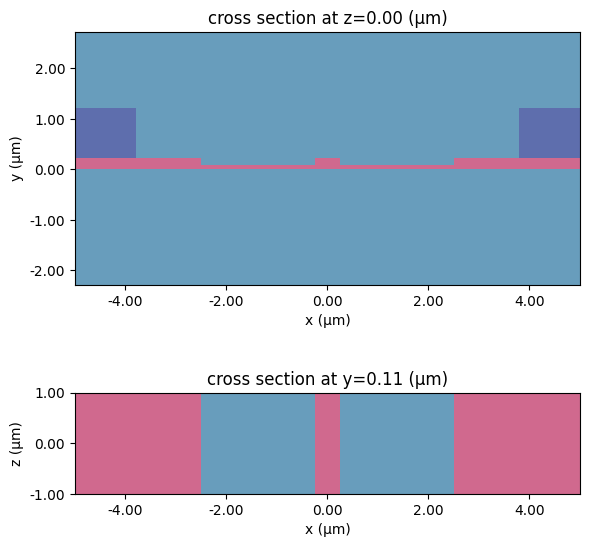

In [11]:
# create a scene with the previous structures
all_structures = [
    oxide,
    core_p,
    core_n,
    clearance_n,
    clearance_p,
    side_p,
    side_n,
    contact_p,
    contact_n,
]

scene = td.Scene(
    medium=air,
    structures=all_structures,
)


_, ax = plt.subplots(2, 1, figsize=(6, 6))

scene.plot(z=0, ax=ax[0])
scene.plot(y=h_core / 2, ax=ax[1])
plt.tight_layout()
plt.show()

And to make sure our doping concentration regions are correct, we can visualize them with the convenience function [plot_structures_property](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Scene.html#tidy3d.Scene.plot_structures_property). 

In the plots below, we have used `property="doping"`, but we can also use `property="acceptors"` or `property="donors"` to check individual doping concentration regions. 

<Axes: title={'center': 'cross section at z=0.00 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

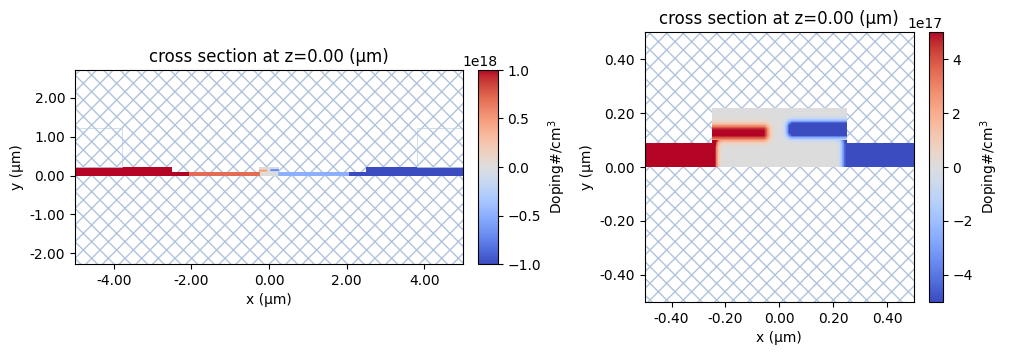

In [12]:
# plot doping from scene
_, ax = plt.subplots(1, 2, figsize=(12, 3.5))
scene.plot_structures_property(z=0, property="doping", ax=ax[0], limits=[-1e18, 1e18])
scene.plot_structures_property(
    z=0, property="doping", ax=ax[1], hlim=[-0.5, 0.5], vlim=[-0.5, 0.5], limits=[-5e17, 5e17]
)

### Charge Boundary Conditions

In this example, we will apply a DC voltage bias across the modulator junction at different voltages. We can do this by using the `VoltageBC` defined at both the p and n regions of the simulation region. This boundary condition accepts a [td.DCVoltageSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DCVoltageSource.html#tidy3d.DCVoltageSource) model. This `DCVoltageSource` accepts a single float or an array of floats. In the latter case, a computation result for each of the voltages defined in the array will be calculated. 

The modulator will operate in reverse bias. This means a zero voltage is applied to the p side and a scalar positive voltage is applied to the n side.

In [13]:
# create BCs
voltages = list(np.linspace(-0.5, 4, 19, endpoint=True))

bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=0)),
    placement=td.StructureBoundary(structure=contact_p.name),
)

bc_v2 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=voltages)),
    placement=td.StructureBoundary(structure=contact_n.name),
)

boundary_conditions = [bc_v1, bc_v2]

### Create our Monitors

Monitors are used to determine exactly what data is to be extracted from the computation. In the case of a Charge simulation, we can extract electronic properties such as the potential $\psi$, free carriers distribution $\mathbf{J}$, and capacitance $C$.

A [td.SteadyCapacitanceMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SteadyCapacitanceMonitor.html#tidy3d.SteadyCapacitanceMonitor) is used to monitor small signal capacitance within the area/volume defined by the monitor. 

The small signal-capacitance of electrons $C_n$ and holes $C_p$ is computed from the charge due to electrons $Q_n$ and holes $Q_p$ at an applied voltage $V$ at a voltage difference $\Delta V$ between two simulations.

$$
C_{n,p} = \frac{Q_{n,p}(V + \Delta V) - Q_{n,p}(V)}{\Delta V}
$$


Note that if only one solution is calculated (one single voltage data point is computed) the output for this monitor will be empty.

In order to extract the electrostatic potential $\psi$ from our simulation, a [td.SteadyPotentialMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SteadyPotentialMonitor.html#tidy3d.SteadyPotentialMonitor) results in a [td.SteadyPotentialData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SteadyPotentialData.html#tidy3d.SteadyPotentialData).

A [td.SteadyFreeCarrierMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SteadyFreeCarrierMonitor.html#tidy3d.SteadyFreeCarrierMonitor) let us record the steady-state of the free carrier concentration ($\mathbf{J_n}$ electrons and $\mathbf{J_p}$ holes) so that we can visualize results. 

In [14]:
# capacitance monitors
capacitance_global_mnt = td.SteadyCapacitanceMonitor(
    center=(0, 0.14, 0),
    size=(td.inf, td.inf, 0),
    name="capacitance_global_mnt",
)

# charge monitor around the waveguide
charge_3D_mnt = td.SteadyFreeCarrierMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, td.inf), name="charge_3D_mnt", unstructured=True
)

# voltage monitor around waveguide
voltage_monitor_z0 = td.SteadyPotentialMonitor(
    center=(0, 0.14, 0),
    size=(0.6, 0.3, 0),
    name="voltage_z0",
    unstructured=True,
)

# Will be used later for the mode simulations
charge_monitor_z0 = td.SteadyFreeCarrierMonitor(
    center=(0, 0.14, 0),
    size=(td.inf, td.inf, 0),
    name="charge_z0_big",
    unstructured=True,
    conformal=True,
)

### Mesh and Convergence criteria
Before we can actually create the simulation object, we need to define some mesh parameters and convergence/tolerance criteria. 

The Charge solver relies on a Finite Volume (FV) space discretization which is formally second order accurate in space. This convergence order is achieved if the mesh is "slowly varying". In practice, this requirement translates in the fact that the mesh needs to be sufficiently fine in regions of spatially varying quantities of interest. In our case, carriers change rapidly in areas of rapidly varying doping which will need to be refined. Additionally, since there is a discontinuity in the permittivity between semiconductor and surrounding oxide, a jump in the gradient of the electric potential field is present which affects the carrier currents near the semiconductor-oxide interface. These will also be refined as seen below

In [15]:
# mesh
junction_relative_h = 0.75
w_structure = 2 * (w_core / 2 + w_clearance + w_side)

dl_boundaries = res * 0.17
dist_boundaries = dl_boundaries * 2
dist_bulk = dist_boundaries * 20

ref_region_core = td.GridRefinementRegion(
    center=(0.0, h_core / 2, 0),
    size=(w_core, h_core, 0),
    dl_internal=res * 0.5,
    transition_thickness=res * 60,
)

ref_region_n_plus = td.GridRefinementRegion(
    center=(2 + 0.08, h_clearance / 2, 0),
    size=(0.05, h_clearance, 0),
    dl_internal=res * 0.4,
    transition_thickness=res * 40,
)

ref_region_p_plus = td.GridRefinementRegion(
    center=(-2 - 0.08, h_clearance / 2, 0),
    size=(0.05, h_clearance, 0),
    dl_internal=res * 0.4,
    transition_thickness=res * 40,
)

ref_region_p_contact = td.GridRefinementRegion(
    center=(-w_core / 2 - w_clearance - w_side + w_contact / 2, h_side + h_contact / 2, 0),
    size=(w_contact, h_contact, 0),
    dl_internal=res * 2,
    transition_thickness=res * 50,
)

ref_region_n_contact = td.GridRefinementRegion(
    center=(w_core / 2 + w_clearance + w_side - w_contact / 2, h_side + h_contact / 2, 0),
    size=(w_contact, h_contact, 0),
    dl_internal=res * 2,
    transition_thickness=res * 50,
)

ref_line_bottom = td.GridRefinementLine(
    r1=(-w_structure / 2, 0.0, 0),
    r2=(w_structure / 2, 0.0, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

ref_line_top_1 = td.GridRefinementLine(
    r1=(-(w_core / 2 + w_clearance), h_clearance, 0),
    r2=(-w_core / 2, h_clearance, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

ref_line_top_2 = td.GridRefinementLine(
    r1=(w_core / 2, h_clearance, 0),
    r2=((w_core / 2 + w_clearance), h_clearance, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

ref_line_core_top = td.GridRefinementLine(
    r1=(-w_core / 2, h_core, 0),
    r2=(w_core / 2, h_core, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

ref_line_core_left = td.GridRefinementLine(
    r1=(-w_core / 2, h_clearance, 0),
    r2=(-w_core / 2, h_core, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

ref_line_core_right = td.GridRefinementLine(
    r1=(w_core / 2, h_clearance, 0),
    r2=(w_core / 2, h_core, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

ref_line_side_p = td.GridRefinementLine(
    r1=(-w_structure / 2, h_side, 0),
    r2=(-w_structure / 2 + w_side, h_side, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

ref_line_side_p1 = td.GridRefinementLine(
    r1=(-w_structure / 2 + w_side, h_clearance, 0),
    r2=(-w_structure / 2 + w_side, h_side, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

ref_line_side_n = td.GridRefinementLine(
    r1=(w_structure / 2, h_side - dl_boundaries * 0, 0),
    r2=(w_structure / 2 - w_side, h_side - dl_boundaries * 0, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

ref_line_side_n1 = td.GridRefinementLine(
    r1=(w_structure / 2 - w_side, h_clearance, 0),
    r2=(w_structure / 2 - w_side, h_side, 0),
    dl_near=dl_boundaries,
    distance_near=dist_boundaries,
    distance_bulk=dist_bulk,
)

# mesh
mesh = td.DistanceUnstructuredGrid(
    dl_interface=res * 1.2,
    dl_bulk=res * 20,
    distance_interface=res * 1,
    distance_bulk=dist_bulk,
    relative_min_dl=0,
    sampling=500,
    # uniform_grid_mediums=[Si_2D_doping.name],
    non_refined_structures=[oxide.name],
    mesh_refinements=[
        ref_region_core,
        ref_region_n_plus,
        ref_region_p_plus,
        ref_region_n_contact,
        ref_region_p_contact,
        ref_line_top_1,
        ref_line_top_2,
        ref_line_bottom,
        ref_line_core_top,
        ref_line_core_left,
        ref_line_core_right,
        ref_line_side_p,
        ref_line_side_n,
        ref_line_side_p1,
        ref_line_side_n1,
    ],
)

Convergence settings are defined next though the `ChargeToleranceSpec` class which is
 an input to the `IsothermalSteadyChargeDCAnalysis`.

One important thing to note here is that to run a Charge simulation we need to specify it in the `HeatChargeSimulation` class. We do this by specifying the parameter `analysis_spec` to an `IsothermalSteadyChargeDCAnalysis` since that is the type of analysis that we're interested in running. 
Note that this class takes the argument `convergence_dv`. To understand how this parameter affects convergence, let's imagine a case where we want to solve for 0 V and 20 V bias. In this case the solver will first try to solve the 0V bias case and based off of this solution will go ahead and try to solve the 20V bias case. Since these are two very different biases, the solver may find it difficult to solve the second. By setting e.g.,`convergence_dv=10` we'll force the solver to go from 0V to 20V in 10V steps which eases convergence.

In [16]:
# devsim setting
convergence_settings = td.ChargeToleranceSpec(
    rel_tol=1e-5, abs_tol=1e5, max_iters=400, ramp_up_iters=1
)

# currently we support Isothermal cases only. Temperature in K
analysis_type = td.IsothermalSteadyChargeDCAnalysis(
    temperature=300, convergence_dv=10, tolerance_settings=convergence_settings
)

### Create our `HeatChargeSimulation`
We're now ready to create the actual simulation object. 

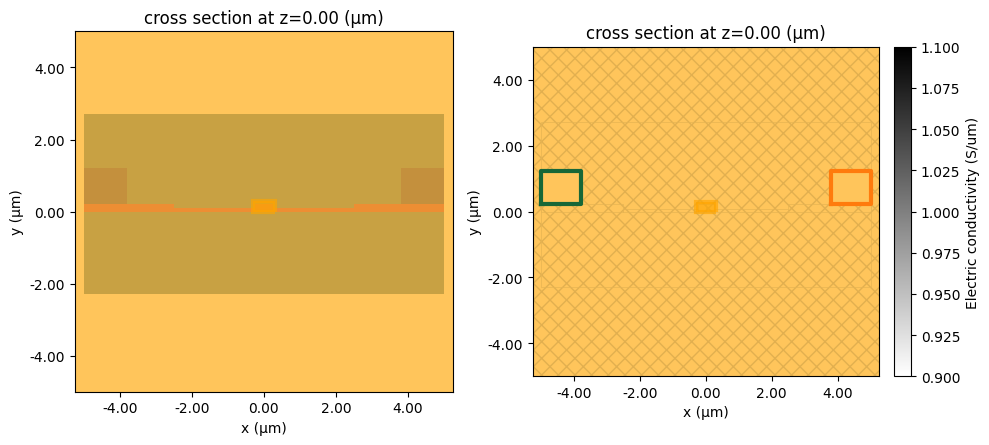

In [17]:
# build heat simulation object
charge_sim = td.HeatChargeSimulation(
    sources=[],
    monitors=[
        capacitance_global_mnt,
        charge_3D_mnt,
        voltage_monitor_z0,
        charge_monitor_z0,
    ],
    analysis_spec=analysis_type,
    center=(0, 0, 0),
    size=(10.5, 10, 0),
    structures=all_structures,
    medium=air,
    boundary_spec=boundary_conditions,
    grid_spec=mesh,
    symmetry=(0, 0, 0),
)

# plot simulation
fig, ax = plt.subplots(1, 2, figsize=(10, 15))
charge_sim.plot(z=0, ax=ax[0])
charge_sim.plot_property(z=0, property="electric_conductivity", ax=ax[1])
plt.tight_layout()
plt.show()

### Run and visualize mesh

Before we submit the charge simulation for solving, we can inspect the mesh. This is particularly important here since the results for reverse-biased `pn`-junctions are usually very sensitive to the mesh especially in the depletion region, and since we have added many mesh refinement regions.

To visualize the mesh, we will build a [VolumeMesher](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.VolumeMesher.html) object using the simulation that we have defined, and a [VolumeMeshMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.VolumeMeshMonitor.html) covering the entire simulation plane.

In [18]:
mesh_monitor = td.VolumeMeshMonitor(size=(td.inf, td.inf, 0), name="mesh")
mesher = td.VolumeMesher(
    simulation=charge_sim,
    monitors=[mesh_monitor],
)

In [19]:
job = web.Job(simulation=mesher, task_name="charge_mesh")
mesher_data = job.run()

19:32:04 CEST Created task 'charge_mesh' with task_id                           
              'vom-617f00bc-9dfc-4309-aac6-530893ebcf23' and task_type          
              'VOLUME_MESH'.

              Tidy3D's VolumeMesher solver is currently in the beta stage. Cost 
              of VolumeMesher simulations is subject to change in the future.

Output()

19:32:06 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

19:32:07 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

19:32:12 CEST starting up solver

              running solver

19:32:23 CEST status = success

Output()

19:32:25 CEST loading simulation from simulation_data.hdf5

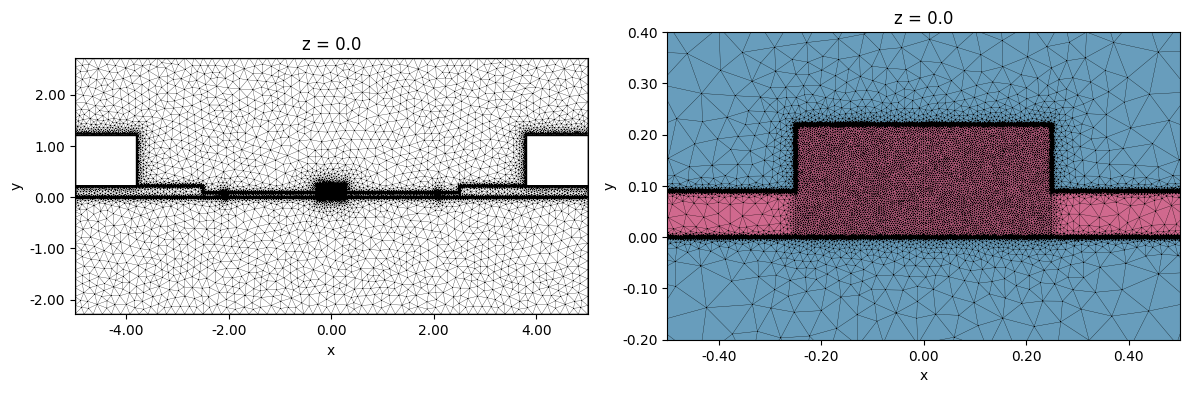

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Mesh overlay over structures outlines only
mesher_data.plot_mesh("mesh", ax=ax[0], structures_fill=False)

# # Mesh overlay over structures plotted in false color
mesher_data.plot_mesh("mesh", ax=ax[1], structures_fill=True)
ax[1].set_xlim([-0.5, 0.5])
ax[1].set_ylim([-0.2, 0.4])

plt.tight_layout()
plt.show()

### Run Simulation

If we have already done the meshing for a solver, we can avoid redoing it by passing the `task_id` of the meshing task.

In [21]:
charge_data = web.run(
    charge_sim,
    task_name="charge_junction",
    path="charge_junction.hdf5",
    parent_tasks=[job.task_id],
)

19:32:26 CEST Created task 'charge_junction' with task_id                       
              'hec-1e8a65d2-f9cb-4de0-b15f-6850c13226c2' and task_type          
              'HEAT_CHARGE'.

              Tidy3D's HeatCharge solver is currently in the beta stage. Cost of
              HeatCharge simulations is subject to change in the future.

Output()

19:32:28 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

19:32:29 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

19:44:48 CEST status = preprocess

19:44:55 CEST starting up solver

              running solver

19:49:30 CEST status = success

Output()

19:49:34 CEST loading simulation from charge_junction.hdf5

### Post-process Charge simulation
Let's begin by visualizing the potential and electron fields at three different biases to make sure the solution looks reasonable. As it can be seen in the figure, as the (reverse) bias increases, the depletion region widens, as it is expected. The electric potential field also adapts to the applied biases and the amount of charge present in the waveguide area, which is also to be expected. 

/home/yannick/flexcompute/worktrees/release_29/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


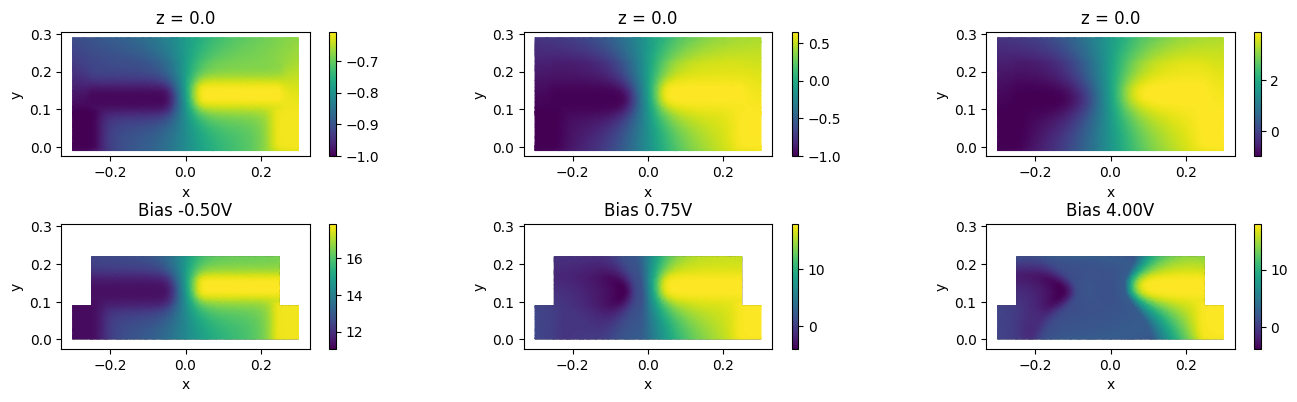

In [22]:
voltages = charge_data[charge_3D_mnt.name].holes.values.voltage.data

fig, ax = plt.subplots(2, 3, figsize=(14, 4))
for n, index in enumerate([0, 5, 18]):
    # let's read voltage first
    charge_data[voltage_monitor_z0.name].potential.sel(voltage=voltages[index]).plot(
        ax=ax[0][n], grid=False
    )

    # now let's plot some electrons
    np.log10(charge_data[charge_3D_mnt.name].electrons.sel(z=0, voltage=voltages[index])).plot(
        ax=ax[1][n], grid=False
    )
    ax[1][n].set_title(f"Bias {voltages[index]:0.2f}V")

plt.tight_layout()

## 2. Experimental Data Validation

In the second section of this example, we will validate the simulation numerical results with the experimental results from [1].

### Small Signal Capacitance

The [td.HeatChargeSimulationData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.HeatChargeSimulationData.html) contains the extracted [td.SteadyCapacitanceData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SteadyCapacitanceData.html) specified by the monitor. The small signal capacitance is computed both with electrons and holes, and is averaged. As seen below, there is reasonable agreement between experimental data and simulation data (within the convergence tolerance).

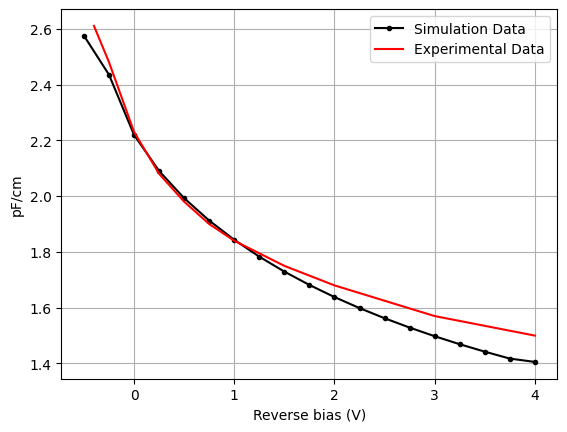

In [23]:
# capacitance from monitor - waveguide area
CV_baehrjones = [
    [-0.4, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4],
    [0.261, 0.248, 0.223, 0.208, 0.198, 0.190, 0.184, 0.175, 0.168, 0.157, 0.150],
]

mnt_v = np.array(charge_data[capacitance_global_mnt.name].electron_capacitance.coords["v"].data)
mnt_ce = np.array(charge_data[capacitance_global_mnt.name].electron_capacitance.data)
mnt_ch = np.array(charge_data[capacitance_global_mnt.name].hole_capacitance.data)

plt.plot(mnt_v, -0.5 * (mnt_ce + mnt_ch) * 10, "k.-", label="Simulation Data")
plt.plot(CV_baehrjones[0], np.array(CV_baehrjones[1]) * 10, "r-", label="Experimental Data")

plt.xlabel("Reverse bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()

### Charge-to-Optical Coupling

In this section, we will explore how we can couple the Charge simulation data into an optical FDTD simulation. This can be implemented by defining a medium perturbation. This means that optical medium properties such as the refractive index change e.g. $\Delta n \propto \varepsilon(N_e, N_h)$ and optical loss $\alpha \propto \sigma(N_e, N_h)$ are proportional to changes to the permittivity $\varepsilon$ and conductivity $\sigma$ by the free electrons $N_e$ and free holes $N_h$ density.

We start by defining the optical frequency range of interest:

In [24]:
wvl_um = 1.55
freq0 = td.C_0 / wvl_um

fwidth = freq0 / 5
freqs = np.linspace(freq0 - fwidth / 10, freq0 + fwidth / 10, 201)
wvls = td.C_0 / freqs

We extract the real ($n$) and imaginary ($k$) parts of the refractive index from our silicon optical medium from our material library.

In [25]:
si = td.material_library["cSi"]["Palik_Lossless"]
n_si, k_si = si.nk_model(frequency=td.C_0 / wvl_um)
si_non_perturb = td.Medium.from_nk(n=n_si, k=k_si, freq=freq0)

### Perturbation Mediums Specifications

To compute the pertubationWe will use empiric relationships presented in [M. Nedeljkovic, R. Soref and G. Z. Mashanovich, "Free-Carrier Electrorefraction and Electroabsorption Modulation Predictions for Silicon Over the 1–14-  μm  Infrared Wavelength Range," IEEE Photonics Journal, vol. 3, no. 6, pp. 1171-1180, Dec. 2011](https://doi.org/10.1109/JPHOT.2011.2171930), that state that changes in $n$ and $k$ of Si can be described by formulas
$$ - \Delta n = \frac{dn}{dN_e}(\lambda) (\Delta N_e)^{a(\lambda)} + \frac{dn}{dN_h}(\lambda) (\Delta N_h)^{\beta(\lambda)}$$
$$ \Delta \left( \frac{4 \pi k}{\lambda} \right) = \frac{dk}{dN_e}(\lambda) (\Delta N_e)^{\gamma(\lambda)} + \frac{dk}{dN_h}(\lambda) (\Delta N_h)^{\delta(\lambda)}$$
where $\Delta N_e$ and $\Delta N_h$ are electron and hole densities. 

For convenience this model has been implemented as [NedeljkovicSorefMashanovich](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.NedeljkovicSorefMashanovich.html)

We need to create an optical simulation. This means we need to slightly modify our existing `Scene` used in our `HeatChargeSimulation`. In order to do this, we will define the charge to optical coupling through a `PerturbationMedium`. This medium will enable us to input the numerical results from our `HeatChargeSimulationData` and change the optical medium properties.

Note that until we apply the carrier densities to the simulation the perturbation medium isn't aware by how much permittivity/conductivity is going to change. This results in warnings every time the perturbation medium is added to a structure. Later in this notebook, when we apply the actual carrier concentrations, we can check by how much the permittivity is changing. 

In [26]:
perturbation_model = td.NedeljkovicSorefMashanovich(ref_freq=freq0)

si_perturb = td.PerturbationMedium.from_unperturbed(
    medium=si_non_perturb,
    perturbation_spec=td.IndexPerturbation(
        delta_n=perturbation_model.delta_n(),
        delta_k=perturbation_model.delta_k(),
        freq=freq0,
    ),
)

new_structs = []
for struct in charge_sim.structures:
    # NOTE: applying perturbation material to Si
    if struct.medium.name == Si_2D_doping.name:
        new_structs.append(struct.updated_copy(medium=si_perturb))

scene = td.Scene(
    medium=SiO2.optical,  # currently td.Simulation cannot accept a MultiphysicsMedium
    structures=new_structs,
)

19:49:36 CEST WARNING: 'Re(permittivity)' could become less than '1.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(conductivity)' could become less than '0.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(permittivity)' could become less than '1.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(conductivity)' could become less than '0.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(permittivity)' could become less than '1.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(conductivity)' could become less than '0.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(permittivity)' could become less than '1.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(conductivity)' could become less than '0.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(permittivity)' could become less than '1.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(conductivity)' could become less than '0.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(permittivity)' could become less than '1.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(conductivity)' could become less than '0.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(permittivity)' could become less than '1.0' for a    
              perturbation medium.                                              

              WARNING: 'Re(conductivity)' could become less than '0.0' for a    
              perturbation medium.                                              

### Creating an Optical Mode Simulation

Let's create an optical mode simulation with our updated scene.

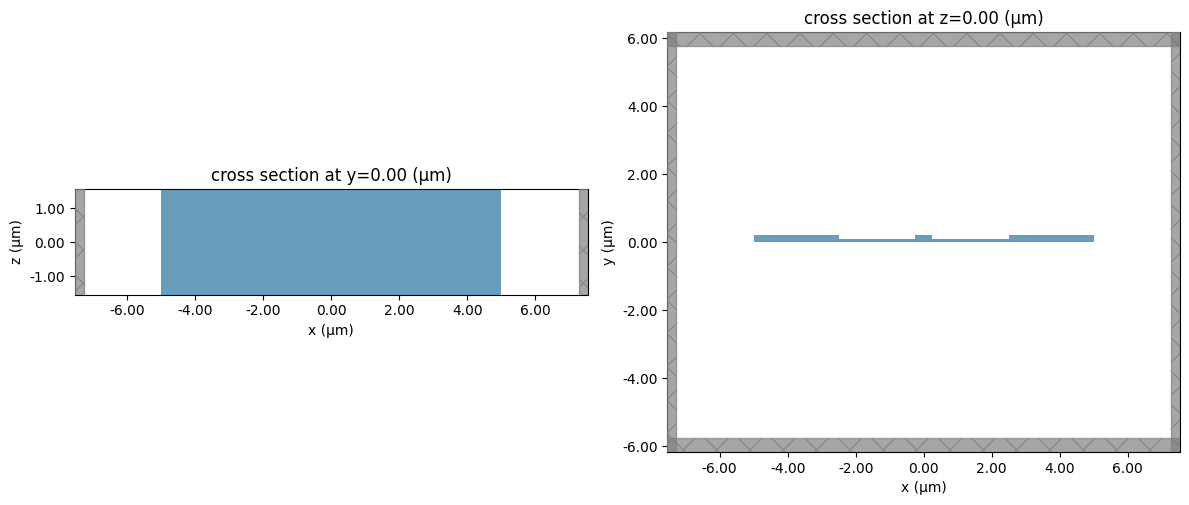

In [27]:
span = 2 * wvl_um

port_center = (0, h_core, -span / 2)
port_size = (3, 3, 0)

buffer = 1 * wvl_um
sim_size = (13 + buffer, 10 + buffer, span)

bc_spec = td.BoundarySpec(
    x=td.Boundary.pml(num_layers=20),
    y=td.Boundary.pml(num_layers=30),
    z=td.Boundary.periodic(),
)

sim = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    medium=scene.medium,
    structures=scene.structures,
    run_time=6e-12,
    boundary_spec=bc_spec,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=60, wavelength=wvl_um),
)

_, ax = plt.subplots(1, 2, figsize=(12, 6))
sim.plot(y=sim.center[1], ax=ax[0])
sim.plot(z=sim.center[2], ax=ax[1])

plt.tight_layout()
plt.show()

### Coupling our `SteadyFreeCarrierData` into our `PerturbationMedium`: 

We already have configured our reference optical mode simulation with the default free carrier distribution. However, our [td.HeatChargeSimulationData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.HeatChargeSimulationData.html) with our [td.SteadyFreeCarrierData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SteadyFreeCarrierData.html) can be used to *perturb* our silicon optical medium. Let's see how we can do this below. Note that we will be using a subset of the applied voltages to reduce the computational resources

We can create a list of perturbed optical simulation by using the function `perturbed_mediums_copy()`:

In [28]:
def apply_charge(charge_data, voltages):
    perturbed_sims = []
    for n, v in enumerate(voltages):
        e_data = charge_data[charge_monitor_z0.name].electrons.sel(voltage=v)
        h_data = charge_data[charge_monitor_z0.name].holes.sel(voltage=v)
        perturbed_sims.append(
            sim.perturbed_mediums_copy(
                electron_density=e_data,
                hole_density=h_data,
            )
        )
    return perturbed_sims


voltage_subset = [-0.5, 0, 1, 2, 3, 4]
perturbed_sims = apply_charge(charge_data, voltages=voltage_subset)
sim_zero_voltage = perturbed_sims[1]

Let's check what the difference in permittivity looks like at different applied voltages, compared to zero voltage.

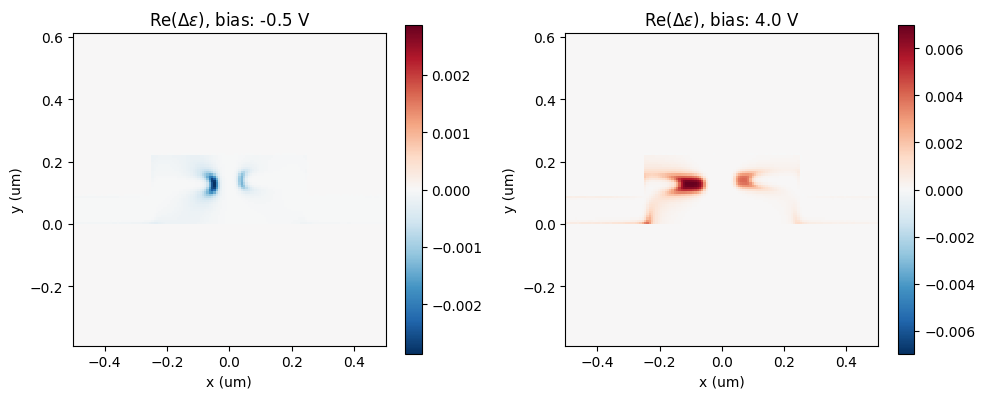

In [29]:
sampling_region = td.Box(center=(0, h_core / 2, 0), size=(1, 1, 1))
eps_zero_voltage = sim_zero_voltage.epsilon(box=sampling_region).sel(z=0, method="nearest")

_, ax = plt.subplots(1, 2, figsize=(10, 4))
for ax_ind, ind in enumerate([0, len(voltage_subset) - 1]):
    eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).sel(z=0, method="nearest")
    eps_doped = eps_doped.interp(x=eps_zero_voltage.x, y=eps_zero_voltage.y)
    eps_diff = np.real(np.real(eps_doped - eps_zero_voltage))
    eps_diff.plot(x="x", ax=ax[ax_ind])

    ax[ax_ind].set_aspect("equal")
    ax[ax_ind].set_title(f"Re($\\Delta \\epsilon$), bias: {voltage_subset[ind]:1.1f} V")
    ax[ax_ind].set_xlabel("x (um)")
    ax[ax_ind].set_ylabel("y (um)")

plt.tight_layout()
plt.show()

### Running Waveguide Mode Simulations

Instead of running a full FDTD simulation, we will compute the modes of the waveguide. 
This is a smaller computation that will also highlight the influence of free carriers fields over the refraction coefficient. 

We will compute the waveguide modes on a plane centered around the core section of the device:

In [30]:
from tidy3d.plugins.mode import ModeSolver

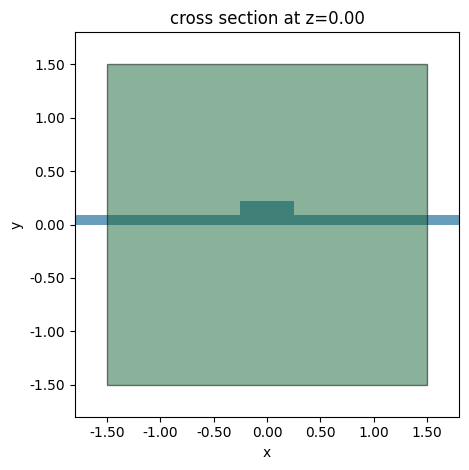

In [31]:
mode_plane = td.Box(size=port_size)

# visualize
ax = sim.plot(z=0)
mode_plane.plot(z=0, ax=ax, alpha=0.5)
plt.show()

In [32]:
mode_solvers = dict()
for i, psim in enumerate(perturbed_sims):
    ms = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        freqs=np.linspace(freqs[0], freqs[-1], 11),
        mode_spec=td.ModeSpec(num_modes=1, precision="single"),
        fields=[],
    )
    mode_solvers[i] = ms

In [33]:
# server mode computation
ms_batch_data = web.Batch(simulations=mode_solvers, reduce_simulation=True).run()

Output()

19:49:54 CEST Started working on Batch containing 6 tasks.

19:50:01 CEST Maximum FlexCredit cost: 0.063 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

19:50:23 CEST Batch complete.

Output()

### Relative Phase Change $\Delta \phi$

Based on the computed effective refractive index $n_{eff}$, we can now determine both phase shift $\Delta \phi$ and $\alpha$ optical loss per cm as a function of the applied bias voltage $V_n$ using the following equations from [1]:


$$
\Delta n_{\text{eff}} = \text{Re}(n_{\text{eff}}(V_n) - n_{\text{eff}}({V_0}))
$$

$$
\Delta \phi = \frac{2\pi \Delta n_{\text{eff}}}{\lambda_0}
$$

$$
\alpha_{\text{dB/cm}} = 10 \cdot 4 \pi \cdot \text{Im}(n_{\text{eff}}) / \lambda_0 \cdot 10^4 \cdot \log_{10}(e)
$$

We compare this to simulation data from another popular simulation software.

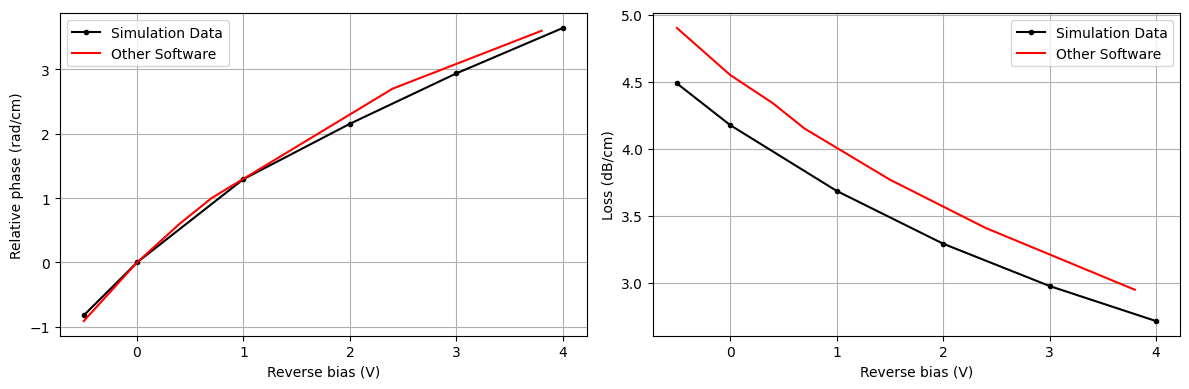

In [34]:
n_eff_freq0 = [md.n_complex.sel(f=freq0, mode_index=0).values for md in ms_batch_data.values()]

ind_V0 = 1
delta_neff = np.real(n_eff_freq0 - n_eff_freq0[ind_V0])
rel_phase_change = 2 * np.pi * delta_neff / wvl_um * 1e4
alpha_dB_cm = 10 * 4 * np.pi * np.imag(n_eff_freq0) / wvl_um * 1e4 * np.log10(np.exp(1))

# other results
v_other = [-0.5, 0, 0.4, 0.7, 1.5, 2.4, 3.8]
pc_other = [-0.91, 0, 0.6, 1, 1.8, 2.7, 3.6]
loss_other = [4.9, 4.55, 4.34, 4.15, 3.77, 3.41, 2.95]

_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(voltage_subset, rel_phase_change, "k.-", label="Simulation Data")
ax[0].plot(v_other, pc_other, "r-", label="Other Software")
ax[0].set_xlabel("Reverse bias (V)")
ax[0].set_ylabel("Relative phase (rad/cm)")
ax[0].grid()
ax[0].legend()

ax[1].plot(voltage_subset, alpha_dB_cm, "k.-", label="Simulation Data")
ax[1].plot(v_other, loss_other, "r-", label="Other Software")
ax[1].set_xlabel("Reverse bias (V)")
ax[1].set_ylabel("Loss (dB/cm)")
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()

As it can be seen, we'd need to apply a bias of ~3.3V in order to get a phase shift of $\pi$.

It is worth noting here that the refractive index and optical loss perturbations from the model in in [M. Nedeljkovic, R. Soref and G. Z. Mashanovich, "Free-Carrier Electrorefraction and Electroabsorption Modulation Predictions for Silicon Over the 1–14-  μm  Infrared Wavelength Range," IEEE Photonics Journal, vol. 3, no. 6, pp. 1171-1180, Dec. 2011](https://doi.org/10.1109/JPHOT.2011.2171930) change significantly at the specified wavelength of 1.55 $\mu m$ and results will also change accordingly. For instance, if one computed the perturbations based on a reference wavelength of 1.575$\mu m$ the following results are obtained:

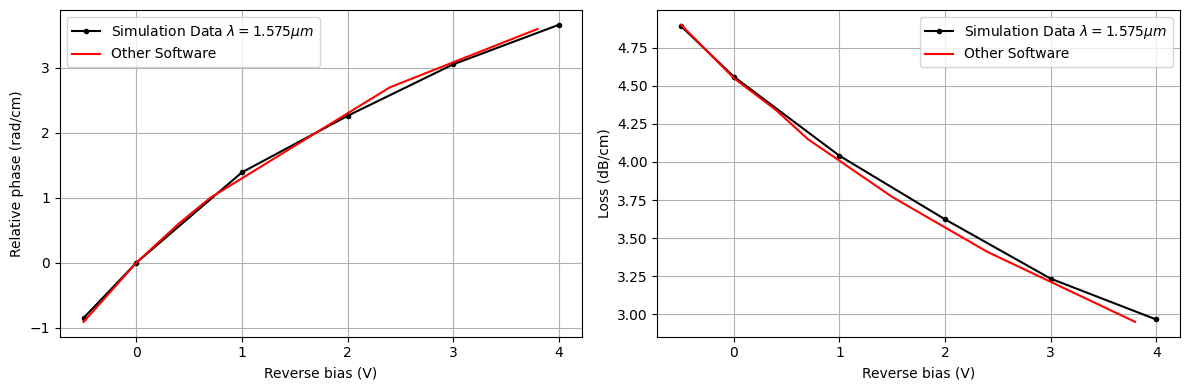

In [35]:
rel_phase_change_1575 = [-0.85049343, 0.0, 1.3917165, 2.2615392, 3.0540445, 3.6629207]
alpha_dB_cm_1575 = [4.891197, 4.5593605, 4.0405374, 3.623057, 3.233821, 2.965634]

_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(
    voltage_subset, rel_phase_change_1575, "k.-", label=r"Simulation Data $\lambda = 1.575 \mu m$"
)
ax[0].plot(v_other, pc_other, "r-", label="Other Software")
ax[0].set_xlabel("Reverse bias (V)")
ax[0].set_ylabel("Relative phase (rad/cm)")
ax[0].grid()
ax[0].legend()

ax[1].plot(
    voltage_subset, alpha_dB_cm_1575, "k.-", label=r"Simulation Data $\lambda = 1.575 \mu m$"
)
ax[1].plot(v_other, loss_other, "r-", label="Other Software")
ax[1].set_xlabel("Reverse bias (V)")
ax[1].set_ylabel("Loss (dB/cm)")
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()